*Libraries*

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib
import shap


*Loading Data*

In [2]:
try:
    data = pd.read_csv('data.csv', encoding='latin1')
except UnicodeDecodeError:
    data = pd.read_csv('data.csv', encoding='cp1252')
print(data.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


*Data Preprocessing*

In [3]:
# Handle missing values
data['CustomerID'] = data['CustomerID'].ffill()

# Handle outliers in Quantity and UnitPrice
q_low = data['Quantity'].quantile(0.01)
q_high = data['Quantity'].quantile(0.99)
data = data[(data['Quantity'] > q_low) & (data['Quantity'] < q_high)]

u_low = data['UnitPrice'].quantile(0.01)
u_high = data['UnitPrice'].quantile(0.99)
data = data[(data['UnitPrice'] > u_low) & (data['UnitPrice'] < u_high)]


*Feature Engineering*

In [4]:
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Aggregate data at the daily level, summing the 'Quantity' column
daily_data = data.set_index('InvoiceDate').resample('D').sum()['Quantity']

# Handle missing values by filling with zero (if any)
daily_data = daily_data.fillna(0)

# Create features for the existing data
daily_data = daily_data.reset_index()
daily_data['Year'] = daily_data['InvoiceDate'].dt.year
daily_data['Month'] = daily_data['InvoiceDate'].dt.month
daily_data['Day'] = daily_data['InvoiceDate'].dt.day
daily_data['DayOfWeek'] = daily_data['InvoiceDate'].dt.dayofweek

# Adding lag features
for lag in [1, 7, 30]:
    daily_data[f'Lag{lag}'] = daily_data['Quantity'].shift(lag)

# Adding moving average features
daily_data['MA7'] = daily_data['Quantity'].rolling(window=7).mean()
daily_data['MA30'] = daily_data['Quantity'].rolling(window=30).mean()

# Drop the initial rows with NaN values created by shifting and rolling
daily_data = daily_data.dropna()


*Training Data*

In [6]:
# Select features and target
features = ['Year', 'Month', 'Day', 'DayOfWeek', 'Lag1', 'Lag7', 'Lag30', 'MA7', 'MA30']
X = daily_data[features]
y = daily_data['Quantity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


*Model Training and Hyperparameter Tuning*

In [7]:
# Initialize the random forest model
random_forest_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Set up the random search with fewer iterations and fewer cross-validation folds
random_search = RandomizedSearchCV(estimator=random_forest_model, 
                                   param_distributions=param_dist, 
                                   n_iter=10, 
                                   cv=3, 
                                   scoring='neg_mean_squared_error', 
                                   random_state=42, 
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters and the best model
print('Best Hyperparameters:', random_search.best_params_)
best_rf_model = random_search.best_estimator_


Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 10}


*Model Evaluation*

Test RMSE: 4726.100854712617


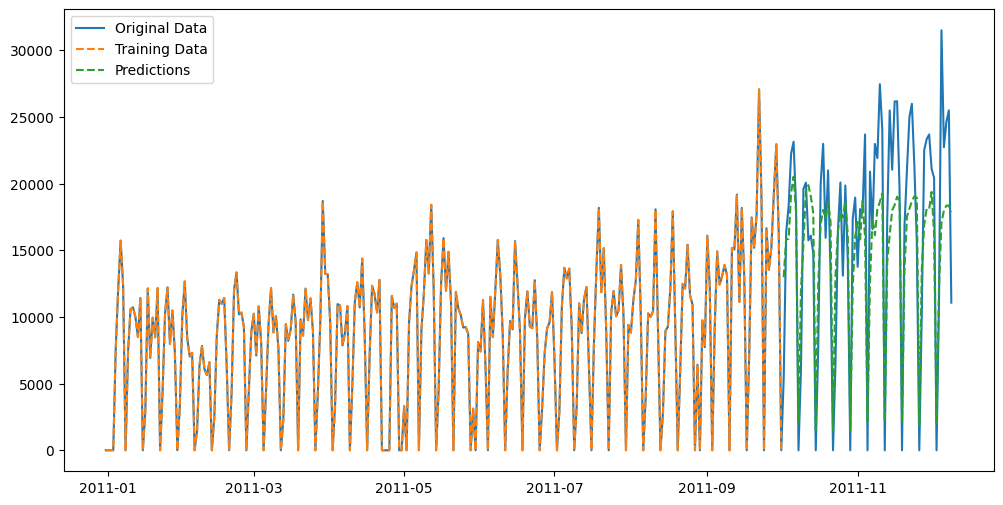

Tuned Random Forest
MAE: 3922.2499621578104
RMSE: 4726.100854712617
R-squared: 0.6660725369049987


In [8]:
# Predict on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE:', rmse)

# Plot the original data and predictions
plt.figure(figsize=(12, 6))
plt.plot(daily_data['InvoiceDate'], daily_data['Quantity'], label='Original Data')
plt.plot(daily_data.loc[X_train.index, 'InvoiceDate'], y_train, label='Training Data', linestyle='--')
plt.plot(daily_data.loc[X_test.index, 'InvoiceDate'], y_pred, label='Predictions', linestyle='--')
plt.legend()
plt.show()

# Predictions with the tuned Random Forest model
y_pred_best_rf = best_rf_model.predict(X_test)

print('Tuned Random Forest')
print('MAE:', mean_absolute_error(y_test, y_pred_best_rf))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_best_rf)))
print('R-squared:', r2_score(y_test, y_pred_best_rf))


*Model Interpretability*

 94%|=================== | 259/275 [00:12<00:00]       

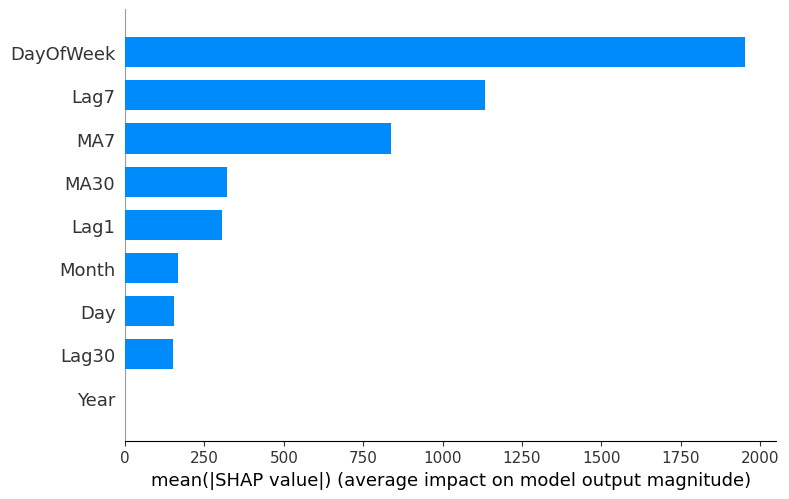

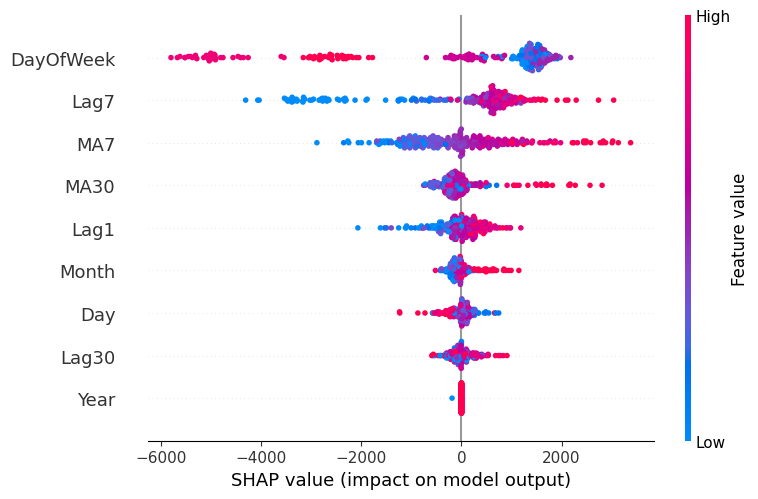

In [9]:
# SHAP values for model interpretability
explainer = shap.Explainer(best_rf_model, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)


*Cross Validation*

In [10]:

cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
print('Cross-Validation RMSE:', np.sqrt(-cv_scores.mean()))


Cross-Validation RMSE: 3427.415088041156


*Saving the model*

In [11]:

joblib.dump(best_rf_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

*User Input and Prediction*

In [14]:
def get_user_inputs():
    user_data = []
    num_predictions = int(input("Enter the number of predictions you want to make: "))
    
    for _ in range(num_predictions):
        year = int(input("Enter Year: "))
        month = int(input("Enter Month: "))
        day = int(input("Enter Day: "))
        day_of_week = pd.Timestamp(f"{year}-{month}-{day}").dayofweek
        lag1 = float(input("Enter Lag1 (previous day's quantity): "))
        lag7 = float(input("Enter Lag7 (quantity 7 days ago): "))
        lag30 = float(input("Enter Lag30 (quantity 30 days ago): "))
        ma7 = float(input("Enter MA7 (7-day moving average): "))
        ma30 = float(input("Enter MA30 (30-day moving average): "))
        
        user_data.append([year, month, day, day_of_week, lag1, lag7, lag30, ma7, ma30])
    
    return pd.DataFrame(user_data, columns=['Year', 'Month', 'Day', 'DayOfWeek', 'Lag1', 'Lag7', 'Lag30', 'MA7', 'MA30'])


def make_prediction(input_data):
    model = joblib.load('random_forest_model.pkl')
    predictions = model.predict(input_data)
    return predictions

if __name__ == "__main__":
    user_inputs = get_user_inputs()
    predictions = make_prediction(user_inputs)
    for i, prediction in enumerate(predictions, 1):
        print(f'Predicted Quantity for input {i}: {prediction}')


Enter the number of predictions you want to make:  1
Enter Year:  2023
Enter Month:  12
Enter Day:  4
Enter Lag1 (previous day's quantity):  52
Enter Lag7 (quantity 7 days ago):  58
Enter Lag30 (quantity 30 days ago):  69
Enter MA7 (7-day moving average):  4
Enter MA30 (30-day moving average):  4


Predicted Quantity for input 1: 4401.653181818182
